In [1]:
!pip install BeautifulSoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
from ast import literal_eval
import io
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

from gensim.test.utils import common_texts
from gensim.models import Word2Vec

#Food.com

In [ ]:
!unzip RAW_recipes.csv.zip
!unzip RAW_interactions.csv.zip

Archive:  RAW_recipes.csv.zip
  inflating: RAW_recipes.csv         
Archive:  RAW_interactions.csv.zip
  inflating: RAW_interactions.csv    


In [ ]:
recipes = pd.read_csv('RAW_recipes.csv')
interactions = pd.read_csv('RAW_interactions.csv')

##Data Preparation

In [ ]:
recipes.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


array([[<AxesSubplot:title={'center':'n_steps'}>,
        <AxesSubplot:title={'center':'n_ingredients'}>]], dtype=object)

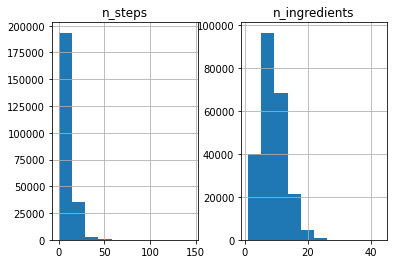

In [ ]:
recipes[['n_steps', 'n_ingredients']].hist()

<AxesSubplot:>

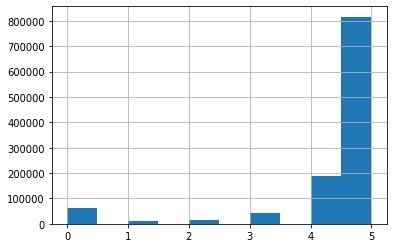

In [ ]:
interactions['rating'].hist()

<AxesSubplot:xlabel='minutes'>

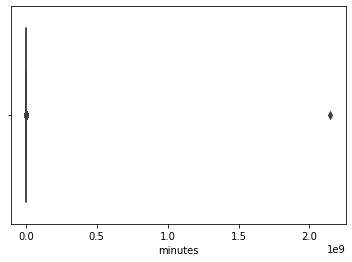

In [ ]:
sns.boxplot(x=recipes["minutes"])

In [ ]:
recipes = recipes.query('minutes < 0.4e6')

<AxesSubplot:xlabel='minutes'>

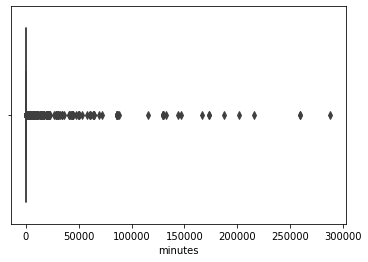

In [ ]:
sns.boxplot(x=recipes["minutes"])

In [ ]:
recipes = recipes.drop(['minutes','contributor_id','nutrition','n_steps','n_ingredients','submitted',], axis=1)

In [ ]:
recipes

,name,id,tags,steps,description,ingredients
0,arriba baked winter squash mexican style,137739,"['60-minutes-or-less', 'time-to-make', 'course...","['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ..."
1,a bit different breakfast pizza,31490,"['30-minutes-or-less', 'time-to-make', 'course...","['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg..."
2,all in the kitchen chili,112140,"['time-to-make', 'course', 'preparation', 'mai...","['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato..."
3,alouette potatoes,59389,"['60-minutes-or-less', 'time-to-make', 'course...",['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n..."
4,amish tomato ketchup for canning,44061,"['weeknight', 'time-to-make', 'course', 'main-...",['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar..."
...,...,...,...,...,...,...
231632,zydeco soup,486161,"['ham', '60-minutes-or-less', 'time-to-make', ...","['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar..."
231633,zydeco spice mix,493372,"['15-minutes-or-less', 'time-to-make', 'course...",['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po..."
231634,zydeco ya ya deviled eggs,308080,"['60-minutes-or-less', 'time-to-make', 'course...","['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must..."
231635,cookies by design cookies on a stick,298512,"['30-minutes-or-less', 'time-to-make', 'course...",['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh..."


In [ ]:
ratings_by_recipe = interactions.groupby(['recipe_id']).agg(
    rating_cnt = ('rating', 'count'),
    rating_avg = ('rating', 'mean'),
)
ratings_by_recipe.head()

,rating_cnt,rating_avg
recipe_id,,
38,4,4.250000
39,1,3.000000
40,9,4.333333
41,2,4.500000
43,1,1.000000


In [ ]:
recipes_with_ratings = recipes.merge(ratings_by_recipe, left_on='id', right_on='recipe_id')
recipes_with_ratings

,name,id,tags,steps,description,ingredients,rating_cnt,rating_avg
0,arriba baked winter squash mexican style,137739,"['60-minutes-or-less', 'time-to-make', 'course...","['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",3,5.0
1,a bit different breakfast pizza,31490,"['30-minutes-or-less', 'time-to-make', 'course...","['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",4,3.5
2,all in the kitchen chili,112140,"['time-to-make', 'course', 'preparation', 'mai...","['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",1,4.0
3,alouette potatoes,59389,"['60-minutes-or-less', 'time-to-make', 'course...",['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",2,4.5
4,amish tomato ketchup for canning,44061,"['weeknight', 'time-to-make', 'course', 'main-...",['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",1,5.0
...,...,...,...,...,...,...,...,...
231630,zydeco soup,486161,"['ham', '60-minutes-or-less', 'time-to-make', ...","['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",6,5.0
231631,zydeco spice mix,493372,"['15-minutes-or-less', 'time-to-make', 'course...",['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",1,5.0
231632,zydeco ya ya deviled eggs,308080,"['60-minutes-or-less', 'time-to-make', 'course...","['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",5,5.0
231633,cookies by design cookies on a stick,298512,"['30-minutes-or-less', 'time-to-make', 'course...",['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",1,1.0


In [ ]:
recipes_with_ratings['tags'] = recipes_with_ratings['tags'].apply(lambda x: literal_eval(str(x)))
recipes_with_ratings['ingredients'] = recipes_with_ratings['ingredients'].apply(lambda x: literal_eval(str(x)))
recipes_with_ratings['steps'] = recipes_with_ratings['steps'].apply(lambda x: literal_eval(str(x)))
recipes_with_ratings['vegan'] = ['vegan' in tag for tag in recipes_with_ratings['tags']]

In [ ]:
recipes_with_ratings['key'] = 1
vegan_df = recipes_with_ratings[recipes_with_ratings['vegan'] == True]
vegan_df = vegan_df.sort_values('rating_cnt', ascending=False).head(2000)
vegan_df = vegan_df.reset_index()
nonvegan_df = recipes_with_ratings[recipes_with_ratings['vegan'] == False]
nonvegan_df = nonvegan_df.reset_index()

In [ ]:
combined = []
for i in range(len(nonvegan_df)):
  combined.append('Name: ' + str(nonvegan_df['name'][i]) + ' Ingredients: ' + ', '.join(nonvegan_df['ingredients'][i]) + ' Steps: ' + '. '.join(nonvegan_df['steps'][i]))
nonvegan_df['combined'] = combined

In [ ]:
combined = []
for i in range(len(vegan_df)):
  combined.append('Name: ' + str(vegan_df['name'][i]) + ' Ingredients: ' + ', '.join(vegan_df['ingredients'][i]) + ' Steps: ' + '. '.join(vegan_df['steps'][i]))
vegan_df['combined'] = combined

In [ ]:
vegan_df

,index,name,id,tags,steps,description,ingredients,rating_cnt,rating_avg,vegan,key,combined
0,1598,5 minute vegan pancakes,132263,"[15-minutes-or-less, time-to-make, course, pre...","[set out all your ingredients, set a stove ele...","a cinch to make and tastes wonderful, if you l...","[flour, sugar, baking powder, salt, soymilk, v...",482,3.354772,True,1,Name: 5 minute vegan pancakes Ingredients: flo...
1,161233,pizza dough for thin crust pizza,70165,"[weeknight, time-to-make, course, preparation,...","[mix a little sugar into the warm water, sprin...",note:this is one of the recipes i adopted in t...,"[all-purpose flour, active dry yeast, salt, wa...",400,4.595000,True,1,Name: pizza dough for thin crust pizza Ingredi...
2,175288,roasted cauliflower 16 roasted cloves of garlic,106251,"[60-minutes-or-less, time-to-make, course, mai...","[mix oil , rosemary , salt , pepper and garlic...","i find it totally amazing, that children and m...","[cauliflower, garlic cloves, fresh rosemary, s...",357,4.753501,True,1,Name: roasted cauliflower 16 roasted cloves ...
3,77574,easy peezy pizza dough bread machine pizza dough,35805,"[weeknight, time-to-make, course, preparation,...","[some pizza topping ideas, caramelised onions ...","this is a really easy way to make a good ""yeas...","[granulated yeast, bread flour, salt, sugar, o...",275,4.440000,True,1,Name: easy peezy pizza dough bread machine pi...
4,13191,baja black beans corn and rice,55768,"[60-minutes-or-less, time-to-make, course, mai...","[cook brown rice, in a medium bowl , combine b...",a south of the border blend of textures and fl...,"[cooked brown rice, black beans, corn, fresh t...",230,4.630435,True,1,Name: baja black beans corn and rice Ingredie...
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,110935,indian cauliflower potatoes,468635,"[curries, weeknight, 60-minutes-or-less, time-...","[combine garam masala , ground coriander , chi...","this is my go-to indian recipe. it's fast, eas...","[ground cumin, ground turmeric, chili powder, ...",5,4.800000,True,1,Name: indian cauliflower potatoes Ingredient...
1996,176066,roasted red pepper coconut soup,341438,"[60-minutes-or-less, time-to-make, course, mai...","[warm oil over medium heat in large stock pot,...",from the moosewood restaurant! i took home an ...,"[red bell peppers, vegetable oil, onions, garl...",5,3.600000,True,1,Name: roasted red pepper coconut soup Ingredie...
1997,93828,golden delicious oatmeal,121111,"[30-minutes-or-less, time-to-make, course, mai...","[combine all but the oatmeal in saucepan, brin...",another goodie with oatmeal. update:12/05. i ...,"[unsweetened apple juice, golden delicious app...",5,4.600000,True,1,Name: golden delicious oatmeal Ingredients: un...
1998,89942,garlic and parsley hearthbreads,120353,"[time-to-make, course, main-ingredient, prepar...","[preheat oven to 375 degrees, combine the flou...",these are something between garlic nan and her...,"[white bread flour, fast rise yeast, salt, war...",5,4.000000,True,1,Name: garlic and parsley hearthbreads Ingredie...


In [ ]:
vegan_df.to_csv('vegan_food.csv')

In [ ]:
nonvegan_df.to_csv('nonvegan_food.csv')

In [ ]:
def get_overlap(vegan_df,i,nonvegan_df):
  overlap = []
  for j in range(len(nonvegan_df)):
    ingr_overlap = len(list(set(vegan_df['ingredients'][i]).intersection(nonvegan_df['ingredients'][j])))/max(len(nonvegan_df['ingredients'][j]),len(vegan_df['ingredients'][i]))
    if ingr_overlap > 0.5:
      overlap.append(j)
  return overlap

In [ ]:
get_overlap(vegan_df,32,nonvegan_df)

#Madens Verden

```
Nonvegan:
  Aftensmad
  Brunch
  Dessert
  Diverse
  Forretter
  Morgenmad


Vegan:
  Vegansk
```

In [3]:
def getlinks_mv(page_url):
  links = []
  response = requests.get(page_url)
  contents = response.text
  soup = BeautifulSoup(contents, 'html.parser')
  information = soup.find('div', class_ = 'feast-category-index feast-recipe-index')
  for link in information.find_all('a'):
    links.append(link.get('href'))
  return(links)

In [4]:
def getrecipe_mv(page_url):
  try:
    response = requests.get(page_url)
    contents = response.text
    soup = BeautifulSoup(contents, 'html.parser') 

    name = soup.find('h1', class_ = 'entry-title').text

    tags = list(map(lambda x: x['content'].split(':')[0], soup.find_all(property = 'slick:category')))

    ingredients = soup.find('div', class_ = 'wprm-recipe-ingredient-group') 
    ingr_name = list(map(lambda x: x.text.strip(), ingredients.find_all('span', class_='wprm-recipe-ingredient-name')))
    ingr_amount = list(map(lambda x: x.text.strip(), ingredients.find_all('span', class_='wprm-recipe-ingredient-amount')))
    ingr_unit = list(map(lambda x: x.text.strip(), ingredients.find_all('span', class_='wprm-recipe-ingredient-unit')))

    steps = soup.find('div', class_ = 'wprm-recipe-instruction-group') 
    steps = list(map(lambda x: x.text.strip(), steps.find_all(class_ = 'wprm-recipe-instruction-text')))

    return name, tags, ingr_name, ingr_amount, ingr_unit, steps   
  except:
    return "None", [], [], [], [], []

In [5]:
def data_mv(page,n):
  links = []
  links.append(page)
  for i in range(2,n+1):
    links.append(page + 'page/' + str(i) + '/')  

  names = []
  tags = []
  ingr_names = []
  ingr_amounts = []
  ingr_units = []
  steplists = []
  urls = []
  for link in links:
    urls += getlinks_mv(link)

  urllen = len(urls)
  counter = 0

  for url in urls:
    counter += 1
    print( str(counter/urllen*100) + '%')
    result = getrecipe_mv(url)
    names.append(result[0])
    tags.append(result[1])
    ingr_names.append(result[2])
    ingr_amounts.append(result[3])
    ingr_units.append(result[4])
    steplists.append(result[5])
  
  d = {'names' : names, 'tags' : tags, 'ingr_names' : ingr_names, 'ingr_amounts' : ingr_amounts, 'ingr_units' : ingr_units, 'steps' : steplists}
  df = pd.DataFrame(data=d)
  return df

In [6]:
hovedretter = data_mv('https://madensverden.dk/category/aftensmad/',10)

0.25%
0.5%
0.75%
1.0%
1.25%
1.5%
1.7500000000000002%
2.0%
2.25%
2.5%
2.75%
3.0%
3.25%
3.5000000000000004%
3.75%
4.0%
4.25%
4.5%
4.75%
5.0%
5.25%
5.5%
5.75%
6.0%
6.25%
6.5%
6.75%
7.000000000000001%
7.249999999999999%
7.5%
7.75%
8.0%
8.25%
8.5%
8.75%
9.0%
9.25%
9.5%
9.75%
10.0%
10.25%
10.5%
10.75%
11.0%
11.25%
11.5%
11.75%
12.0%
12.25%
12.5%
12.75%
13.0%
13.25%
13.5%
13.750000000000002%
14.000000000000002%
14.249999999999998%
14.499999999999998%
14.75%
15.0%
15.25%
15.5%
15.75%
16.0%
16.25%
16.5%
16.75%
17.0%
17.25%
17.5%
17.75%
18.0%
18.25%
18.5%
18.75%
19.0%
19.25%
19.5%
19.75%
20.0%
20.25%
20.5%
20.75%
21.0%
21.25%
21.5%
21.75%
22.0%
22.25%
22.5%
22.75%
23.0%
23.25%
23.5%
23.75%
24.0%
24.25%
24.5%
24.75%
25.0%
25.25%
25.5%
25.75%
26.0%
26.25%
26.5%
26.75%
27.0%
27.250000000000004%
27.500000000000004%
27.750000000000004%
28.000000000000004%
28.249999999999996%
28.499999999999996%
28.749999999999996%
28.999999999999996%
29.25%
29.5%
29.75%
30.0%
30.25%
30.5%
30.75%
31.0%
31.25%
31.5%
31

In [7]:
hovedretter = hovedretter.drop(hovedretter[hovedretter.names == 'None'].index)
hovedretter = hovedretter.reset_index()

In [11]:
combined = []
for i in range(len(hovedretter)):
  combined.append('Name: ' + str(hovedretter['names'][i]) + '\n\nIngredients:\n' + '\n'.join(hovedretter['ingr_names'][i]) + '\n\nSteps:\n' + '\n'.join(hovedretter['steps'][i]))
hovedretter['combined'] = combined

In [12]:
hovedretter

,index,names,tags,ingr_names,ingr_amounts,ingr_units,steps,combined
0,0,Broccolilasagne - nem og sund opskrift uden kød,[aftensmad],"[broccoli, gulerødder, rød peberfrugt, løg, hv...","[400, 200, 1, 100, 4, 2, 1, 3, 4, 2, 2, 1, 1]","[gram, gram, gram, fed, spiseskefulde, dåse, s...",[Til broccolilasagne starter du med at gøre gr...,Name: Broccolilasagne - nem og sund opskrift u...
1,1,Karrykødsovs med ris og grøntsager,"[aftensmad, populaere-opskrifter]","[hakket kalv og svin, olie, løg, gulerødder, k...","[375, 2, 1, 150, 2]","[gram, spiseskefulde, stort, gram, teskefulde]",[Rør bouillonterning ud i det kogende vand til...,Name: Karrykødsovs med ris og grøntsager\n\nIn...
2,2,Millionbøf med kartoffelmos eller pasta,"[aftensmad, populaere-opskrifter]","[hakket oksekød, løg, bouillon, laurbærblade, ...","[500, 2, 5, 2, 1, 1]","[gram, deciliter, spiseskefuld, spiseskefuld]",[Om du laver retten i en gryde eller pande er ...,Name: Millionbøf med kartoffelmos eller pasta\...
3,3,Flæskesteg i ovn med sprød svær (den sikre ops...,"[aftensmad, julemad, populaere-opskrifter]","[svinekam, salt og friskkværnet peber]","[1,5]",[kilo],"[Tjek først og fremmest, at slagteren har skår...",Name: Flæskesteg i ovn med sprød svær (den sik...
4,4,"Klassisk mørbradgryde med ris, bacon og cockta...","[aftensmad, dagens-opskrift, populaere-opskrif...","[bacon, svinemørbrad, hvedemel, champignon, lø...","[200, 1, 1-2, 250, 1, 3, 4, 1, 2, 2, 1, 3]","[gram, spiseskefulde, gram, stort, teskefulde,...","[Kom bacontern i en kold stegegryde, og varm o...","Name: Klassisk mørbradgryde med ris, bacon og ..."
...,...,...,...,...,...,...,...,...
340,395,Svensk mørbrad med hasselback kartofler,[aftensmad],"[mørbrad, champignon, porrer, piskefløde, toma...","[1 -2, 250, 2, 2½, 5, 1½, 1]","[g, dl, spsk., tsk.]",[Skær mørbrad i bøffer à ca. 1-1½ cm. tykkelse...,Name: Svensk mørbrad med hasselback kartofler\...
341,396,Hvidkålsgryde,"[aftensmad, dagens-opskrift]","[hvidkål, løg, hakket svinekød, karry, hakkede...","[1, 2, 500, 2, 1, 2, 2, 1-2]","[lille, gram, teskefulde., dåse, deciliter, te...","[Hvidkål snittes fint, og du skal bruge ca. et...",Name: Hvidkålsgryde\n\nIngredients:\nhvidkål\n...
342,397,Bagt pasta bolognese,"[aftensmad, pasta-opskrifter]","[bacon, rødløg, hvidløg, hakket oksekød, blads...","[150, 1, 4, 400, 3, 3, 0,5, 2, 3, 1, 1, 1, 7, ...","[gram, fed, gram, stængler, dåser, spiseskeful...",[Tænd din ovn på 200 grader almindelig over- o...,Name: Bagt pasta bolognese\n\nIngredients:\nba...
343,398,Ristet hotdog - klassisk hotdog med det hele,[aftensmad],"[pølsebrød, pølser, sennep, tomatketchup, remo...","[4, 4]",[],[Pølsebrød varmes og skæres halvt igennem. Pas...,Name: Ristet hotdog - klassisk hotdog med det ...


In [15]:
hovedretter['combined'][0]

'Name: Broccolilasagne - nem og sund opskrift uden kød\n\nIngredients:\nbroccoli\ngulerødder\nrød peberfrugt\nløg\nhvidløg\nolivenolie\nhakkede tomater\ntomatkoncentrat\nhønsebouillon\nengelsk sauce\noregano\npaprika\ncitron\nsalt og friskkværnet peber\n\nSteps:\nTil broccolilasagne starter du med at gøre grøntsagerne klar. Det vil sige broccoli, gulerødder, peberfrugt, løg og hvidløg. Du kan faktisk med fordel snitte dem i Thermomixer eller anden køkkenmaskine, hvor du kan snitte dem hurtigt.\nSvits grøntsagerne i lidt olie på en meget varm pande i et par minutter, og tilsæt så hakkede tomater, tomatkoncentrat, hønsebouillon, engelsk sauce, oregano og paprika.\nLad det simre mens du laver bechamelsauce, og smag derefter til med lidt friskpresset citronsaft, salt og peber.\nbechamelsauce laver du ved at smelte smør i gryde, hvorefter hvedemel piskes. Pisk derefter mælk i indtil den rette konsistens er opnået. Riv muskatnød i, og smag til med salt. Lad bechamelsaucen simre i 5 minutter 

In [14]:
hovedretter.to_csv('nonvegan_MV.csv')

#Opskrifter

In [ ]:
def cleanstr_o(string):
  string = string.replace('</p>', '')
  string = string.replace('<br/>', '')
  string = re.sub(r'(<strong>).+(</strong>)', '', string)

  return string

In [ ]:
def getlinks_o(page_url):
  links = []
  response = requests.get(page_url)
  contents = response.text
  soup = BeautifulSoup(contents, 'html.parser')
  information = soup.find('div', class_='main-inner')
  for link in soup.find_all('a'):
    if str(link.get('href'))[0:35] == 'https://www.opskrifter.dk/opskrift/':
      links.append(link.get('href'))
  return links

In [ ]:
def getrecipe_o(page_url):
  try:
    ingr_list = []

    response = requests.get(page_url)
    contents = response.text
    soup = BeautifulSoup(contents, 'html.parser')
    ingredients = soup.find_all('li', itemprop='recipeIngredient')
    for ingr in ingredients:
      ingr_list.append(re.sub('\n*\s{2,}\n*', ' ', ingr.text).strip())

    steps = soup.find_all('span', itemprop='description')
    name = steps[0].text
    steplist = steps[1].text          
    #steplist = re.sub('\r', '', steplist)
    #steplist = re.sub('\n\n', '\n', steplist)
    #steplist = steplist.split('\n')
    steplist = [steplist]
    tags = list(map(lambda x: ' '.join(x.text.split()), soup.find_all('a', class_ ='recipe-tag'))) 
    kitchen = soup.find('p', itemprop='recipeCuisine').text
    tags.append(kitchen)
  except:
    return "None", [], [], [], [], []

  return name, tags, ingr_list, steplist

In [ ]:
def data_o(page,n):
  links = []
  links.append(page) #'https://www.opskrifter.dk/kategorier/hovedret'
  for i in range(2,n+1):
    if i % 2 == 0:
      links.append(page + '?query=&page='+str(i))
    else:
      links.append(page + '?page=' + str(i))

  print(links)
  names = []
  tags = []
  ingr = []
  steplists = []

  urls = []
  for link in links:
    urls += getlinks_o(link)

  urllen = len(urls)
  counter = 0

  for url in urls:
    counter += 1
    print(str(counter/urllen*100) + '%')
    result = getrecipe_o(url)
    names.append(result[0])
    tags.append(result[1])
    ingr.append(result[2])
    steplists.append(result[3])

  d = {'names' : names, 'tags' : tags, 'ingredients' : ingr, 'steps' : steplists}
  df = pd.DataFrame(data=d)
  return df

In [ ]:
hovedretter2 = data_o('https://www.opskrifter.dk/kategorier/hovedretter',1)

['https://www.opskrifter.dk/kategorier/hovedretter']
8.333333333333332%
16.666666666666664%
25.0%
33.33333333333333%
41.66666666666667%
50.0%
58.333333333333336%
66.66666666666666%
75.0%
83.33333333333334%
91.66666666666666%
100.0%


In [ ]:
hovedretter2 = hovedretter2.drop(hovedretter2[hovedretter2.names == 'None'].index)
hovedretter2 = hovedretter2.reset_index()
hovedretter2.head()

,index,names,tags,ingredients,steps
0,0,Italiensk tomatsuppe,"[Vegetar, Vegansk Mad, Italiensk]","[1.2 stk Løg, 4 stk Soltørret tomat, 1 tsk Rap...",[Italiensk tomatsuppeOpvarm rapsolien i en gry...
1,1,kyllingefrikadeller i ovn,[Dansk],"[500 gram Hakket kyllingekød, 1 tsk Groft salt...",[kyllingefrikadeller i ovnTag en skål og tilsæ...
2,2,Baked beans,"[Kødretter, Proteinrig mad, Mexicansk]","[500 gram Tørrede hvide bønner, 250 gram Bacon...",[Baked beans\nStart med at udbløde de hvide bø...
3,3,Roastbeef på slow cooker,"[Kødretter, Proteinrig mad, Dansk]","[1 Roastbeef, 1.5 spsk Salt, 0.5 tsk Friskkvær...",[Sådan laver du roastbeef i en slow cookerTag ...
4,4,Pandestegt torsk med rødbeder og syltet citron,"[Fiskeretter, Fedtfattig mad, Proteinrig mad, ...","[1 stk Torskefilet, 1 stk Rå rødbede, 2 stk Sy...",[Pandestegt torsk med rødbeder og syltet citro...


In [ ]:
i = 1
print(hovedretter2['ingredients'][i])
print(hovedretter2['steps'][i])

['500 gram Hakket kyllingekød', '1 tsk Groft salt', '1 stk Æg', '1 stk Løg', '0 Peber', '2 spsk Hvedemel', '1 spsk Rasp', '2 deciliter Mælk', '0 Gulerod']
['kyllingefrikadeller i ovnTag en skål og tilsæt det hakkede kyllingekød, æg og salt og rør det godt sammen. Løget hakkes fint. Kom løg, peber, rasp, hvedemel og lidt mælk i skålen. Rør farsen godt sammen, og tilsæt lidt mere mælk. Kom stille og roligt mere mælk til farsen så den til sidst hverken er godt tynd eller tyk. Du kan tilføje revet gulerod til farsen efter behov. Frikadellerne kan også sagtens laves uden. Stil farsen på køl i ca. 30 min, og tændt ovnen på 200 grader varmluft.Gør en bageplade klar med bagepapir og form ca. 12 frikadeller. Dette kan gøres med hænderne eller ved hjælp af en ske. Hav eventuelt et glas lunket vand ved siden af hvor du kan dype skeen. På den måde vil farsen nemmere give slip. Sæt frikadellerne i ovnen og giv dem ca. 25 min.Du kan eventuelt vende dem undervej på pladen, men dette er ikke et behov.

In [ ]:
text1 = hovedretter2['ingredients'][i][0]
text2 = hovedretter2['steps'][i][0]

In [ ]:
text2 = re.sub('\r', '', text2)
text2 = re.sub('\n\n', '\n', text2)
text2.split('\n')

['Koteletter krydres med salt og peber og brunes på begge sider i margarine, hvorefter de lægges i ildfast fad',
 'Franskbrød, soltørrede tomater, persille, løg, æg og evt. parmesan blandes og fordeles udover koteletterne.',
 'Koteletterne stilles i ovnen ved 200°C i varmluftsovn, eller 225°C i alm. ovn, i ca. 20-25 minutter.',
 'Tomater halveres og lægges på bagepapir, krydres med salt og peber og sættes i ovnen de sidste 10 min. koteletterne står derinde.',
 'Pasta koges efter anvisning og vendes med grillede tomater, optøede ærter og majs.']

#Micadeli

In [ ]:
def getlinks_mic(page_url):
  links = []
  response = requests.get(page_url, headers={"User-Agent": "XY"})   #page_url = 'https://micadeli.dk/veganske-opskrifter/'
  contents = response.text
  soup = BeautifulSoup(contents, 'html.parser')
  main = soup.find('main', id='main')   #ingredients = soup.find_all('h2', class_='entry-title')
  for a in main.find_all('a', href=True):
      links.append( a['href'])
  return links

In [ ]:
def getrecipe_mic(page_url):
  try:
    response = requests.get(page_url, headers={"User-Agent": "XY"})
    contents = response.text
    soup = BeautifulSoup(contents, 'html.parser')
    ingredients = soup.find('div', class_ = 'recipe-ingredients')
    regex = re.compile(r'^\d{1}$')
    ingr_list = [i for i in ingredients.text.split('\n') if i]
    ingr_list = [i for i in ingr_list if not (regex.match(i))]

    steps = soup.find('div', class_ = 'recipe-method')
    steplist = [i for i in steps.text.split('\n') if i]
    steplist = [i for i in steplist if not (regex.match(i))]
    name = []
    tags = []
  except:
    return "None", [], [], []
  
  return name, tags, ingr_list, steplist

In [ ]:
def data_mic(page,n):
  links = []
  links.append(page) #'https://www.opskrifter.dk/kategorier/hovedret'
  for i in range(2,n+1):
    if i % 2 == 0:
      links.append(page + '?query=&page='+str(i))
    else:
      links.append(page + '?page=' + str(i))
  links = list(np.unique(links))

  names = []
  tags = []
  ingr = []
  steplists = []

  urls = []
  for link in links:
    urls += getlinks_mic(link)

  urllen = len(urls)
  counter = 0

  for url in urls:
    counter += 1
    print(str(counter/urllen*100) + '%')
    result = getrecipe_mic(url)
    names.append(result[0])
    tags.append(result[1])
    ingr.append(result[2])
    steplists.append(result[3])

  d = {'names' : names, 'tags' : tags, 'ingredients' : ingr, 'steps' : steplists}
  df = pd.DataFrame(data=d)
  return df

#Albertsgaard

In [ ]:
page_url = 'https://albertestengaard.dk/veganske-opskrifter/'
response = requests.get(page_url)
contents = response.text
soup = BeautifulSoup(contents, 'html.parser')
for a in soup.find_all('a', href=True):
    print("Found the URL:", a['href'])


Found the URL: #main
Found the URL: https://albertestengaard.dk/
Found the URL: https://albertestengaard.dk/
Found the URL: https://albertestengaard.dk/veganske-opskrifter/
Found the URL: https://albertestengaard.dk/veganske-opskrifter/
Found the URL: https://albertestengaard.dk/morgenmad/
Found the URL: https://albertestengaard.dk/salater/
Found the URL: https://albertestengaard.dk/frokost/
Found the URL: https://albertestengaard.dk/aftensmad/
Found the URL: https://albertestengaard.dk/tilbehor/
Found the URL: https://albertestengaard.dk/snacks/
Found the URL: https://albertestengaard.dk/sode-sager/
Found the URL: https://albertestengaard.dk/bagvaerk/
Found the URL: https://albertestengaard.dk/guides/
Found the URL: https://albertestengaard.dk/om-mig/
Found the URL: https://albertestengaard.dk/personligt/
Found the URL: https://albertestengaard.dk/saeson-og-mad-plakater/
Found the URL: https://albertestengaard.dk/kontakt/
Found the URL: #
Found the URL: https://albertestengaard.dk/veg

In [ ]:
page_url = 'https://albertestengaard.dk/bananbrod-med-havregryn/'
response = requests.get(page_url)
contents = response.text
soup = BeautifulSoup(contents, 'html.parser')
print(soup.find_all('li', class_='wprm-recipe-ingredient')[0].text)



300 g banan


In [ ]:
#Lav Micadeli
#Lav albertsgaard
#Sæt testformat op
#Test 1-2 gange
#Sæt Evalueringsformat op
#Prøv sammenligninger